In [2]:
import pandas as pd
data = pd.read_csv("/Users/MrMndFkr/Desktop/Monthly-Traffic-Volume-Analysis/data_reshaped.csv")
data.head()

,State,data_monthid,category,Million_Vehicle_Miles,area,monthid
0,alabama,200401,Rural_Arterial_200212,1298,rural,200212
1,alabama,200401,Urban_Arterial_200212,1550,urban,200212
2,alabama,200401,All_Arterial_200212,4623,all,200212
3,alaska,200401,Rural_Arterial_200212,85,rural,200212
4,alaska,200401,Urban_Arterial_200212,133,urban,200212


In [3]:
data.sort_values('monthid',ascending = True, inplace = True)

In [4]:
data.head()

,State,data_monthid,category,Million_Vehicle_Miles,area,monthid
0,alabama,200401,Rural_Arterial_200212,1298,rural,200212
98,new york,200401,All_Arterial_200212,10645,all,200212
99,north carolina,200401,Rural_Arterial_200212,2096,rural,200212
100,north carolina,200401,Urban_Arterial_200212,2374,urban,200212
101,north carolina,200401,All_Arterial_200212,7426,all,200212


In [5]:
## create the maping of state to sub-region from the dataset
Northeast = list(map(lambda x:x.lower(), ['Connecticut','Maine','Massachusetts','New Hampshire','New Jersey','New York','Pennsylvania','Rhode Island','Vermont']))
Southatlantic = list(map(lambda x:x.lower(), ['Delaware','District of Columbia','Florida','Georgia','Maryland','North Carolina','South Carolina','Virginia','West Virginia']))
Northcentral = list(map(lambda x:x.lower(), ['Illinois','Indiana','Iowa','Kansas','Michigan','Minnesota','Missouri','Nebraska','North Dakota','Ohio','South Dakota','Wisconsin']))
Southgulf = list(map(lambda x:x.lower(), ['Alabama','Arkansas','Kentucky','Louisiana','Mississippi','Oklahoma','Tennessee','Texas']))
West = list(map(lambda x:x.lower(), ['Alaska','Arizona','California','Colorado','Hawaii','Idaho','Montana','Nevada','New Mexico','Oregon','Utah','Washington','Wyoming']))

In [6]:
## apply the mapping to the dataframe
data.loc[data.State.isin(Northeast),'region'] = 'North_East'
data.loc[data.State.isin(Southatlantic),'region'] = 'South_Atlantic'
data.loc[data.State.isin(Northcentral),'region'] = 'North_Central'
data.loc[data.State.isin(Southgulf),'region'] = 'South_Gulf'
data.loc[data.State.isin(West),'region'] = 'West'

In [7]:
## check for dups
QC = data.groupby(['State','monthid','category']).agg({'Million_Vehicle_Miles':['count']}).reset_index()
QC.columns = ['State','monthid','category','value']
QC.iloc[0:10,]
QC.loc[(QC.value > 1)]

,State,monthid,category,value


In [39]:
## get data at month and region level
a = data.loc[data.area == 'all'].groupby(['region','monthid']).agg({'Million_Vehicle_Miles':['sum']}).reset_index()
a.columns = ['region','monthid','miles']
a.sort_values(['region','monthid'],ascending = True, inplace = True)

In [40]:
## get rolling 12 month sum
a['rolling_miles'] = a.groupby('region')['miles'].rolling(12).sum().values

In [41]:
## get date from monthid
a['month'] = a.monthid.astype(str)
a['date'] = pd.to_datetime(a.month, format='%Y%m')
a.head()

,region,monthid,miles,rolling_miles,month,date
0,North_Central,200212,53701,NaN,200212,2002-12-01
1,North_Central,200301,49200,NaN,200301,2003-01-01
2,North_Central,200302,45304,NaN,200302,2003-02-01
3,North_Central,200303,53315,NaN,200303,2003-03-01
4,North_Central,200304,54650,NaN,200304,2003-04-01


In [42]:
## remove nans and recent months as revised data is not available
b = a.loc[(~a.rolling_miles.isna()) & (a.monthid <= 201901)]
b.rolling_miles = b.rolling_miles / 1000000
b.head()

/Users/MrMndFkr/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,region,monthid,miles,rolling_miles,month,date
11,North_Central,200311,52823,0.664789,200311,2003-11-01
12,North_Central,200312,54621,0.665709,200312,2003-12-01
13,North_Central,200401,49470,0.665979,200401,2004-01-01
14,North_Central,200402,46740,0.667415,200402,2004-02-01
15,North_Central,200403,55495,0.669595,200403,2004-03-01


In [43]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [44]:
%R library(scales)

array(['ggrepel', 'ggplot2', 'scales', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [45]:
%R library(ggplot2)

array(['ggrepel', 'ggplot2', 'scales', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [46]:
%R library(ggrepel)

array(['ggrepel', 'ggplot2', 'scales', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

### Get Region level Line Graphs

In [60]:
%R -i b

In [111]:
%%R -w 8 -h 8 --units in -r 400
ggplot(b) +
    geom_line(aes(x=date,y=rolling_miles, group = region), colour = 'grey69') + 
    geom_text(data = subset(b, month == "201901"& (region == 'South_Gulf' | region == 'North_East')), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = -0.6, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'West'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = -0.6, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'North_Central'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = 2, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'South_Atlantic'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = 3.5, colour = 'grey69') +
    theme_minimal() +
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.title.x = element_blank(), legend.position = "None") +
    annotate(geom='rect', xmin = as.POSIXct("2008-01-01", format = "%Y-%m-%d"), xmax = as.POSIXct("2009-03-01", format = "%Y-%m-%d"), ymin = 0.4, ymax = 0.75, alpha = 0.1 ) +
    annotate(geom='text', x = as.POSIXct("2008-07-01", format = "%Y-%m-%d"), y = 0.75, label = '2007 Subprime Mortgage Crisis', vjust = -0.5, fontface = 'italic') +
    ylab("Trillion Vehicular Miles - 12 month moving sum\n") + 
    scale_y_continuous(limits = c(0.4,0.75), breaks = seq(0.4, 0.75, by = 0.05)) + 
    scale_x_datetime(date_breaks = '2 year', labels=date_format('%Y')) +
    labs( title = "Vehicle activity tanked across all regions post 2007 economic recession") + 
    theme(plot.title = element_text(size=16, face = "bold")) +
    theme(plot.title = element_text(hjust = 0.8, vjust = -1.5 ))

ggsave('/Users/MrMndFkr/Desktop/Monthly-Traffic-Volume-Analysis/Region Wise I.pdf', units = 'in', width = 8, height = 8)   


In [110]:
%%R -w 8 -h 8 --units in -r 400
ggplot(b) +
    geom_line(aes(x=date,y=rolling_miles, group = region), colour = 'grey69') + 
    geom_line(data = subset(b, date >= '2014-01-01' & region == 'North_East'), aes(x=date,y=rolling_miles), colour = 'red4') +
    geom_text(data = subset(b, month == "201901" & region == 'South_Gulf'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles),  hjust = 0.8, vjust = -0.6, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'South_Atlantic'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = 3.3, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'North_Central'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = 2, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'West'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = -0.6, colour = 'grey69') +
    geom_text(data = subset(b, month == "201901" & region == 'North_East'), aes(label = gsub("_", " ", region), colour = 'grey69', x = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), y = rolling_miles), hjust = 0.8, vjust = -0.6, colour = 'red4') +
    theme_minimal() +
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(), axis.title.x = element_blank(), legend.position = "None") +
    annotate(geom='rect', xmin = as.POSIXct("2014-01-01", format = "%Y-%m-%d"), xmax = as.POSIXct("2019-01-01", format = "%Y-%m-%d"), ymin = 0.4, ymax = 0.75, alpha = 0.1 ) +
    annotate(geom='text', x = as.POSIXct("2016-07-01", format = "%Y-%m-%d"), y = 0.75, label = 'Economic Growth Post Recession', vjust = -0.5, fontface = 'italic') +
    ylab("Trillion Vehicular Miles - 12 month moving sum\n") + 
    scale_y_continuous(limits = c(0.4,0.75), breaks = seq(0.4, 0.75, by = 0.05)) +
    scale_x_datetime(date_breaks = '2 year', labels=date_format('%Y')) +
    labs( title = "The Uneven Geography of U.S. Economic Growth") + 
    theme(plot.title = element_text(size=16, face = "bold")) +
    theme(plot.title = element_text(vjust = -1.5, hjust = 0.5 ))

ggsave('/Users/MrMndFkr/Desktop/Monthly-Traffic-Volume-Analysis/Region Wise II.pdf', units = 'in', width = 8.5, height = 8)   


### Slope graph for disasters

In [162]:
c = data.loc[(data.State.isin(['florida', 'louisiana', 'mississippi', 'alabama'])) & (data.area.isin(['rural','urban']))]
c.loc[:,'month'] = c.monthid.astype(str)
c.loc[:,'date'] = pd.to_datetime(c.month, format='%Y%m')
c.head()

,State,data_monthid,category,Million_Vehicle_Miles,area,monthid,region,month,date
0,alabama,200401,Rural_Arterial_200212,1298,rural,200212,South_Gulf,200212,2002-12-01
27,florida,200401,Rural_Arterial_200212,2844,rural,200212,South_Atlantic,200212,2002-12-01
28,florida,200401,Urban_Arterial_200212,7083,urban,200212,South_Atlantic,200212,2002-12-01
1,alabama,200401,Urban_Arterial_200212,1550,urban,200212,South_Gulf,200212,2002-12-01
72,mississippi,200401,Rural_Arterial_200212,1167,rural,200212,South_Gulf,200212,2002-12-01


In [163]:
c.sort_values(['State','area','monthid'],ascending = True, inplace = True)
c.loc[:,'rolling_miles'] = c.groupby(['State','area'])['Million_Vehicle_Miles'].rolling(12).sum().values
c.head(20)

/Users/MrMndFkr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,State,data_monthid,category,Million_Vehicle_Miles,area,monthid,region,month,date,rolling_miles
0,alabama,200401,Rural_Arterial_200212,1298,rural,200212,South_Gulf,200212,2002-12-01,NaN
153,alabama,200402,Rural_Arterial_200301,1235,rural,200301,South_Gulf,200301,2003-01-01,NaN
306,alabama,200403,Rural_Arterial_200302,1195,rural,200302,South_Gulf,200302,2003-02-01,NaN
459,alabama,200404,Rural_Arterial_200303,1441,rural,200303,South_Gulf,200303,2003-03-01,NaN
612,alabama,200405,Rural_Arterial_200304,1462,rural,200304,South_Gulf,200304,2003-04-01,NaN
765,alabama,200406,Rural_Arterial_200305,1501,rural,200305,South_Gulf,200305,2003-05-01,NaN
918,alabama,200407,Rural_Arterial_200306,1543,rural,200306,South_Gulf,200306,2003-06-01,NaN
1071,alabama,200408,Rural_Arterial_200307,1703,rural,200307,South_Gulf,200307,2003-07-01,NaN
1224,alabama,200409,Rural_Arterial_200308,1555,rural,200308,South_Gulf,200308,2003-08-01,NaN
1377,alabama,200410,Rural_Arterial_200309,1351,rural,200309,South_Gulf,200309,2003-09-01,NaN


In [167]:
## remove nans and recent months as revised data is not available
d = c.loc[(~c.rolling_miles.isna()) & (c.monthid >= 200501) & (c.monthid <= 200801)]
d.rolling_miles = d.rolling_miles / 1000
d.head()

,State,data_monthid,category,Million_Vehicle_Miles,area,monthid,region,month,date,rolling_miles
3825,alabama,200602,Rural_Arterial_200501,1288,rural,200501,South_Gulf,200501,2005-01-01,17.360
3978,alabama,200603,Rural_Arterial_200502,1260,rural,200502,South_Gulf,200502,2005-02-01,17.383
4131,alabama,200604,Rural_Arterial_200503,1512,rural,200503,South_Gulf,200503,2005-03-01,17.375
4284,alabama,200605,Rural_Arterial_200504,1485,rural,200504,South_Gulf,200504,2005-04-01,17.332
4437,alabama,200606,Rural_Arterial_200505,1506,rural,200505,South_Gulf,200505,2005-05-01,17.316


In [168]:
%R -i d

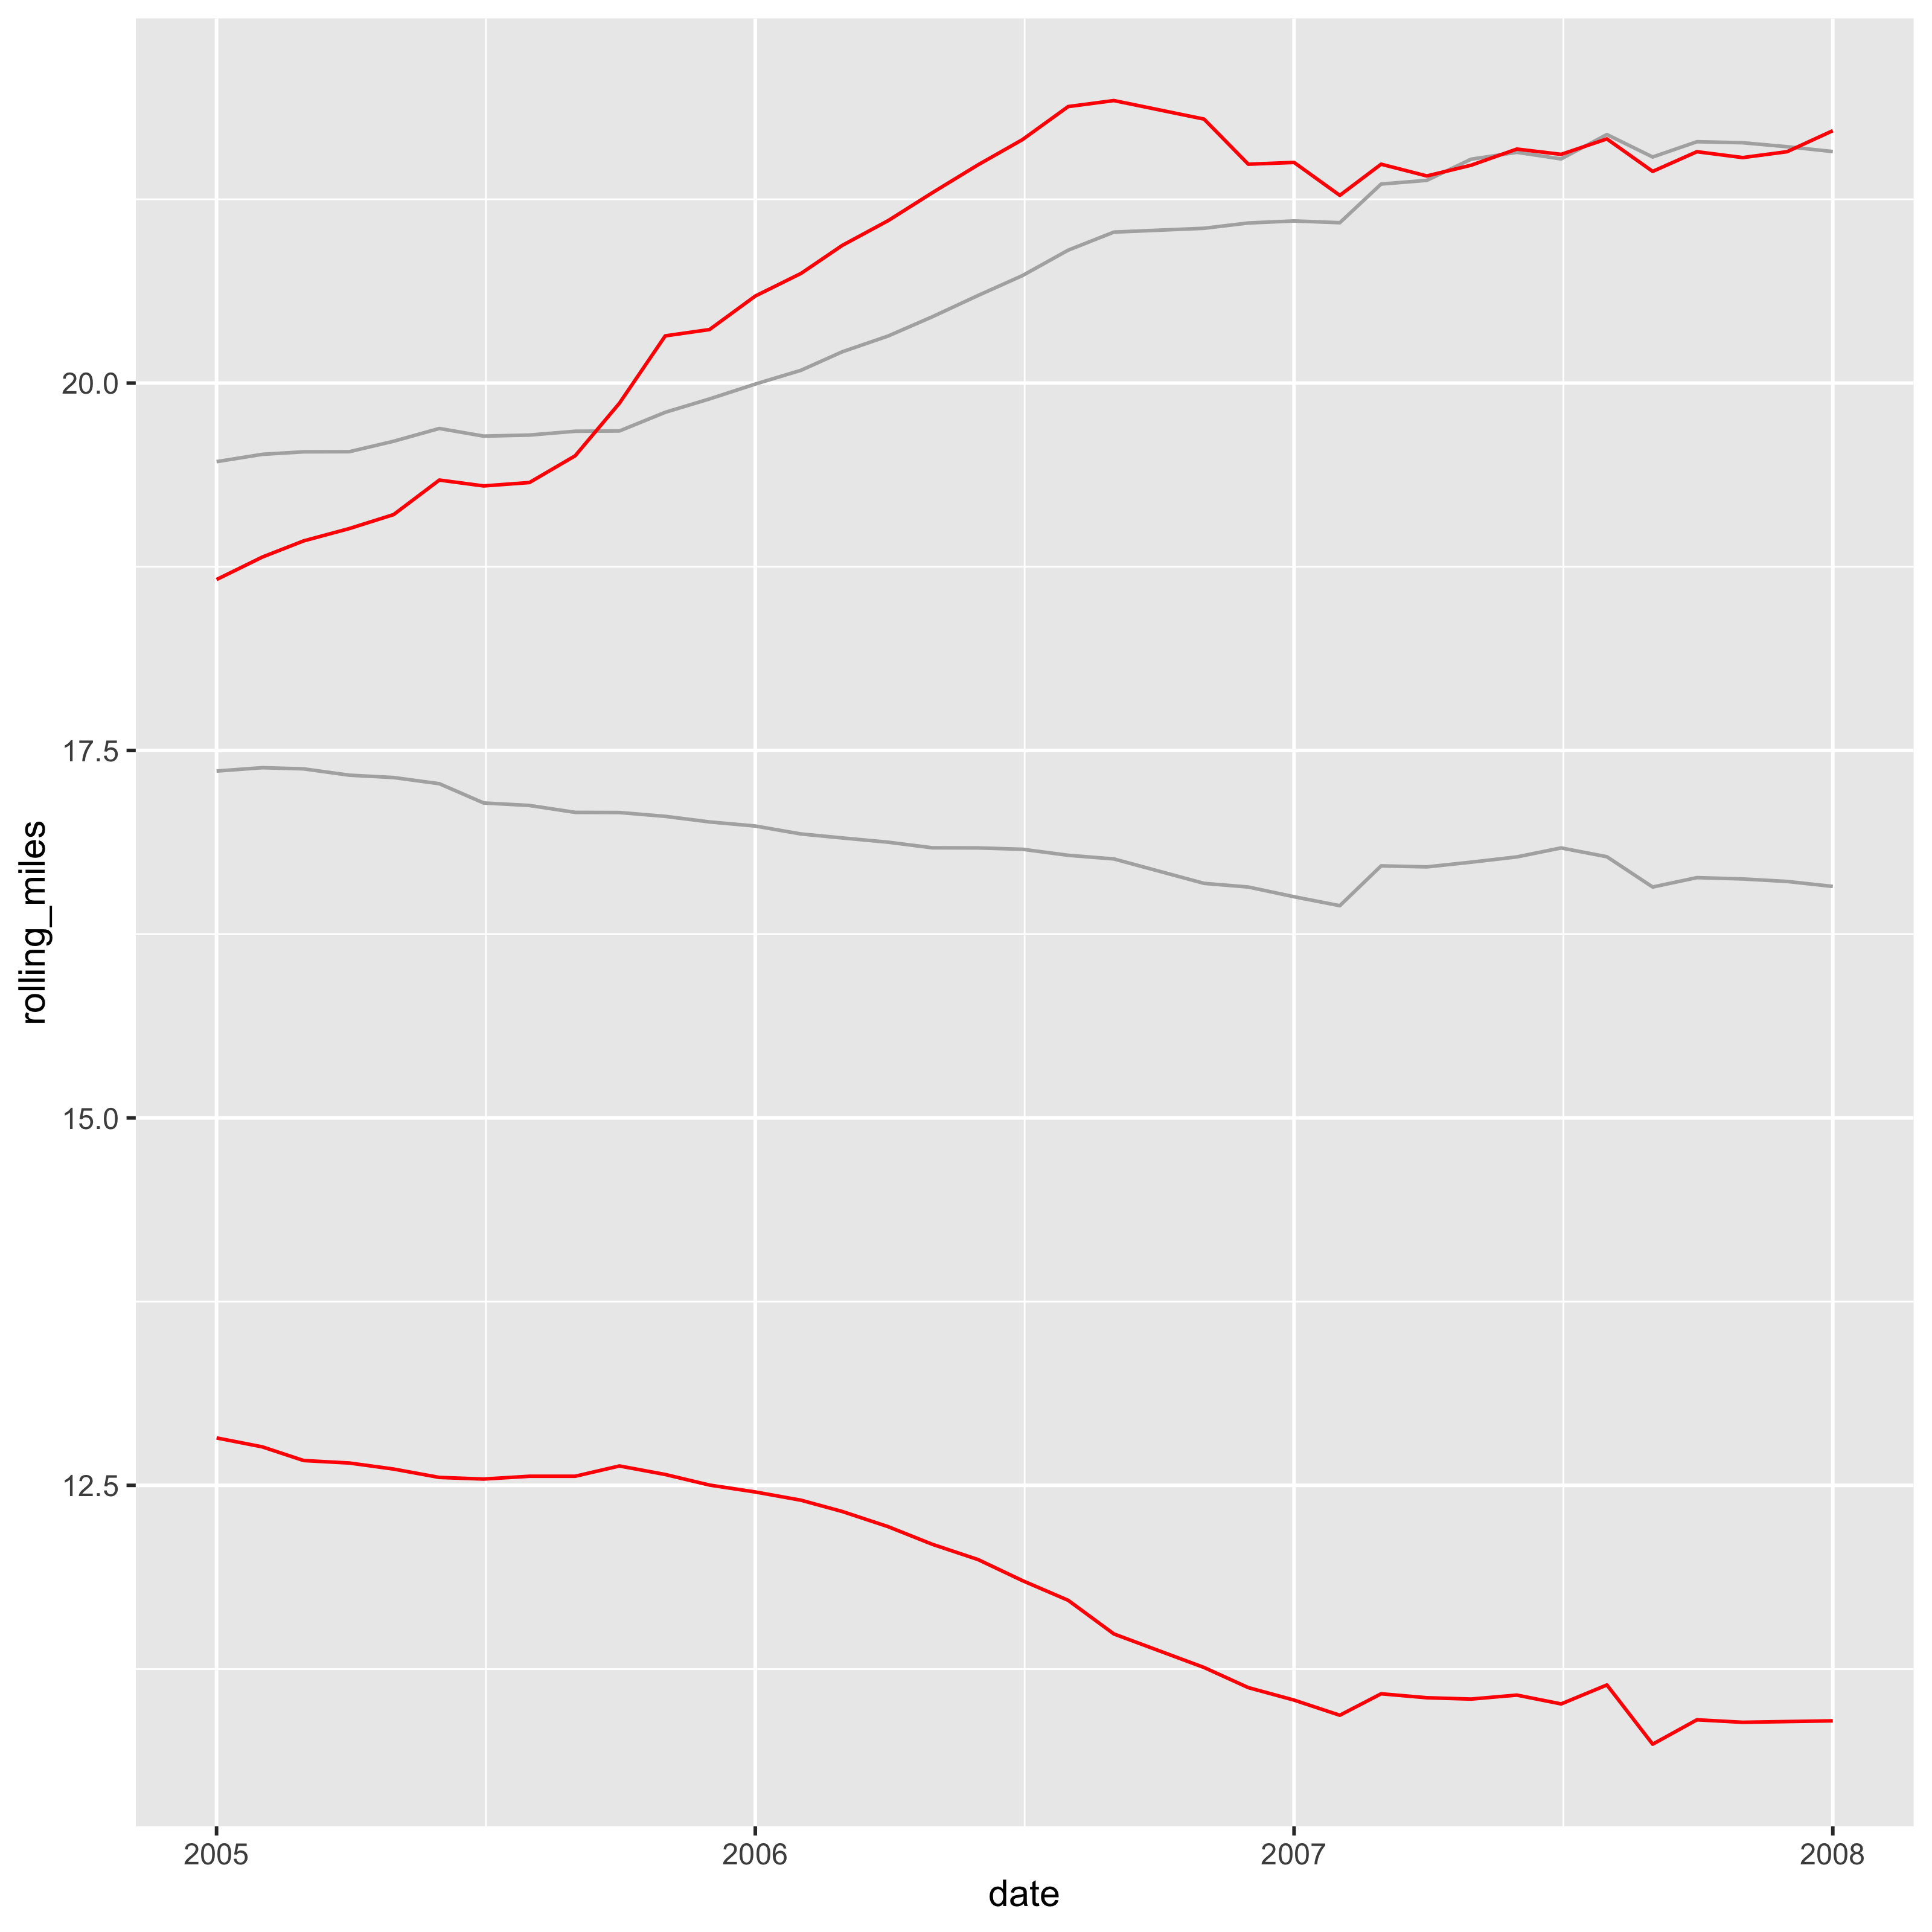

In [182]:
%%R -w 8 -h 8 --units in -r 400
ggplot(d) +
    geom_line(data = subset(d, State == 'alabama'), aes(x=date,y=rolling_miles, group = area), colour = 'grey69') +
    #geom_line(data = subset(d, State == 'mississippi'), aes(x=date,y=rolling_miles, group = area), colour = 'blue4') + 
    #geom_line(data = subset(d, State == 'florida'), aes(x=date,y=rolling_miles, group = area), colour = 'green') + 
    geom_line(data = subset(d, State == 'louisiana'), aes(x=date,y=rolling_miles, group = area), colour = 'red')

### We will show a slope graph for alabama and louisiana - 6 mons before, 6 months after and 12 months after the disaster. Hurricane Katrina happened in Aug end 2005, so we will take Jan 2005, Jan 2006 and Aug 2006. We will have seperate lines for urban and rural areas for contrast